# 03: Demonstrate data preprocessing and exploration
* Some common challenges faced when working with time series data in the real world
* Perform exploratory data analysis to show the characteristics of the data, such as seasonality, trends, and outliers.

In [6]:
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))


from typing import TypeVar, Any

import matplotlib.pyplot as plt 

from data.impute_data import impute

#
# from data.electricity_consumption import energy_demand
from data.india_pollution import india_pollution
from data.dataset import Dataset

## Missing and irregularly spaced data
Time series data might have missing values or unevenly spaced timestamps. To handle this, you can use interpolation methods or resampling techniques provided by the pandas library.


1. **Pandas interpolate**: Pandas `interpolate()` function is used to fill missing values in a dataset by using various interpolation techniques, such as linear, polynomial, or spline interpolation. It's useful when you have a small number of missing values in a time series and want to fill them based on the pattern of the surrounding data points. It's especially useful when the missing data points are located between existing data points with a clear pattern.

2. **Pandas resample**: Pandas `resample()` function is used to change the frequency of the time series data by aggregating or downsampling the data points. It's useful when you have irregularly spaced data or want to change the granularity of the dataset (e.g., from daily to monthly data). You can choose the resampling method, such as mean, sum, or max, to aggregate the data during resampling. This method is particularly helpful when you need to align time series data with different frequencies or fill gaps in irregularly spaced data.

3. **MICE (Multiple Imputation by Chained Equations)**: MICE is an advanced statistical method for imputing missing data by performing multiple imputations. It works by creating multiple copies of the dataset, filling the missing values in each copy using a regression model, and then averaging the results to obtain a single imputed dataset. MICE is useful when you have a large number of missing values or when the missing data is not missing at random. It's particularly helpful when you need to preserve the relationships between variables and account for the uncertainty in the imputed values.


In [7]:
# load the data
city_name = "Ahmedabad"
dataset_object = next(india_pollution(city_list=[city_name], raw=True))

# get the data from the Dataset object
data = dataset_object.values

print(data.head())



INFO:root:Path /Users/frankkelly/Dropbox/Projects-new/india_air_pollution_study/data/air-quality-data-in-india exists
INFO:root:Getting list of city names
INFO:root:Path /Users/frankkelly/Dropbox/Projects-new/india_air_pollution_study/data/air-quality-data-in-india exists


            PM2.5  PM10      O3     CO    SO2    NO2
Date                                                
2015-01-01    NaN   NaN  133.36   0.92  27.64  18.22
2015-01-02    NaN   NaN   34.06   0.97  24.55  15.69
2015-01-03    NaN   NaN   30.70  17.40  29.07  19.30
2015-01-04    NaN   NaN   36.08   1.70  18.59  18.48
2015-01-05    NaN   NaN   39.31  22.10  39.33  21.42


In [8]:
def plot_indian_city_pollution(df: pd.DataFrame, title: str = "Indian city pollution", 
                               scale: bool = False, chosen_metric: str = "PM2.5",
                               set_y_axis_limits: Any = None) -> None:
    """Plots the Indian pollution DataFrame, highlighting any gaps in the data."""
    fig, ax = plt.subplots(figsize=(10, 3))
    
    # Find the gaps in the data
    gap = df[chosen_metric].isnull().astype(int)
    gaps = gap[gap == 1]
    
    plt.plot(df.index, df[chosen_metric])
    
    # Highlight gaps in the data
    if gaps.shape[0] > 0:
        for gap_start, gap_end in zip(gaps.index[:-1], gaps.index[1:]):
            if gap_start != gap_end:
                ax.axvspan(gap_start, gap_end, color='red', alpha=0.2)
    else:
        print("No gaps in data")
    
    plt.xlabel("Date")
    if scale:
        plt.ylabel(f"{chosen_metric}, scaled")
    else:
        plt.ylabel(f"{chosen_metric}, micrograms per cubic meter")


    # Add a legend including the red area
    if gaps.shape[0] > 0:
        plt.legend([f"{chosen_metric}", "Missing data"])
    else:
        plt.legend([f"{chosen_metric}"])

    if set_y_axis_limits is not None:
        plt.ylim(set_y_axis_limits)

    if title is not None:
        title_string = f"{title} - {chosen_metric} for {city_name}"
    else:
        title_string = f"{chosen_metric} for {city_name}"

    plt.title(title_string)
    plt.show()

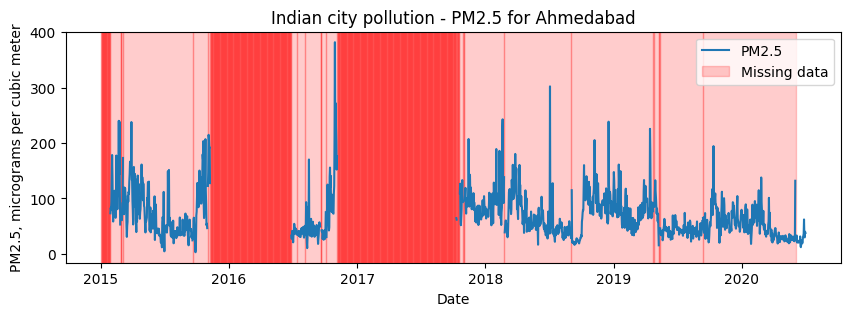

In [9]:
plot_indian_city_pollution(data, scale=False)

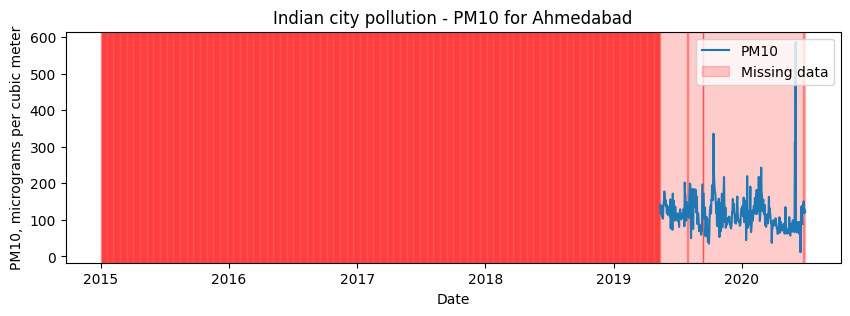

In [10]:
plot_indian_city_pollution(data, scale=False, chosen_metric="PM10")

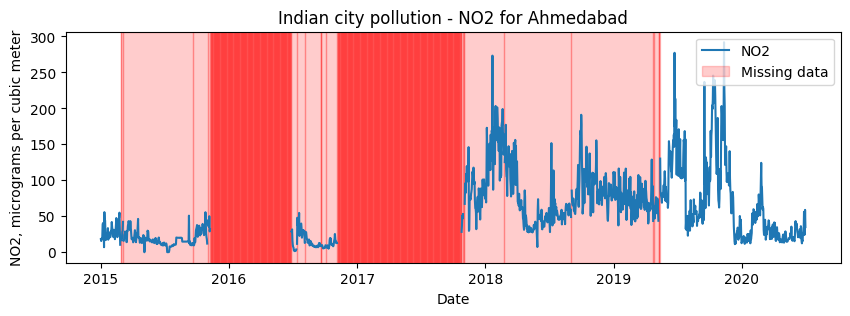

In [11]:
plot_indian_city_pollution(data, scale=False, chosen_metric="NO2")

## Approach 1: Basic interpolation with Pandas


### Pros:
- **Ease of Use**: Apply interpolation with minimal code.
- **Flexible**: Various methods to suit your data's nature, be it linear, polynomial, or spline interpolation.
- **Data Quality**: Make your dataset more comprehensive.

### Cons:
- **Assumptions**: May not accurately represent all data trends.
- **Not for Every Dataset**: Large gaps or non-sequential missing values could introduce bias.
- **Overreliance**: Don't let interpolation mask data collection issues.


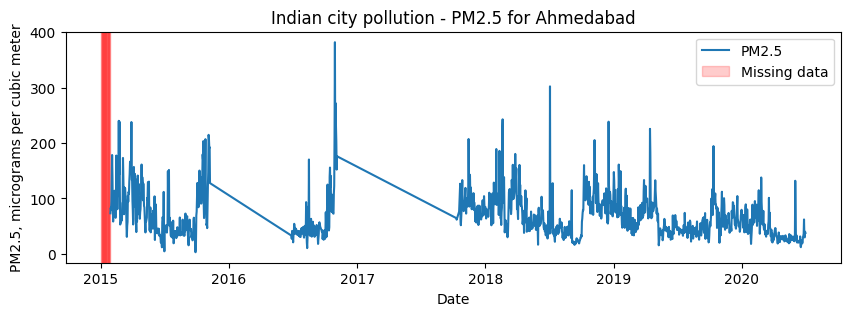

In [16]:
# Approach 1: Basic interpolation with Pandas

# Interpolate the data
data_interpolated = data.interpolate(method="linear")

# Plot the data
plot_indian_city_pollution(data_interpolated, scale=False,)

## Approach 2: **Interpolation with MICE (Multivariate Imputation by Chained Equations)**: 

MICE, an advanced technique that goes beyond basic interpolation, uses multiple regression models to estimate missing values, considering the interdependencies between variables.

### Method Explained:
- **Multiple Imputations**: Creates several imputed datasets to reflect the uncertainty around the missing data.
- **Chained Equations**: Imputes data by iteratively cycling through variables, using each as a response in a regression model.
- **Comprehensive**: Captures the relationships among multiple variables to fill in missing data more accurately.

### Pros:
- **Detailed Analysis**: Accounts for the uncertainty and variability in the data.
- **Versatility**: Works well with complex datasets and can handle different types of variables.
- **Improved Accuracy**: Utilizes the relationships between variables for more precise imputations.

### Cons:
- **Complexity**: More complicated to implement and understand than basic interpolation.
- **Computationally Intensive**: Requires more processing power, especially for large datasets.
- **Assumptions About Data**: Relies on the assumption that the data are missing at random (MAR).



INFO:root:Imputing data for columns Index(['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2'], dtype='object')
INFO:root:columns present: Index(['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2'], dtype='object')
INFO:root:Shape of dataframe before imputation: (2009, 6)
INFO:root:Column PM2.5 has 628; more than 5% missing values, less than 50%, so advanced imputation is necessary
INFO:root:Column PM10 has 1602; less than 5% missing values, so only simple imputation is necessary
INFO:root:Column O3 has 685; more than 5% missing values, less than 50%, so advanced imputation is necessary
INFO:root:Column CO has 609; more than 5% missing values, less than 50%, so advanced imputation is necessary
INFO:root:Column SO2 has 640; more than 5% missing values, less than 50%, so advanced imputation is necessary
INFO:root:Column NO2 has 608; more than 5% missing values, less than 50%, so advanced imputation is necessary
INFO:root:Imputation is necessary
INFO:root:Imputing data with miceforest
INFO:root:Shape of da

No gaps in data


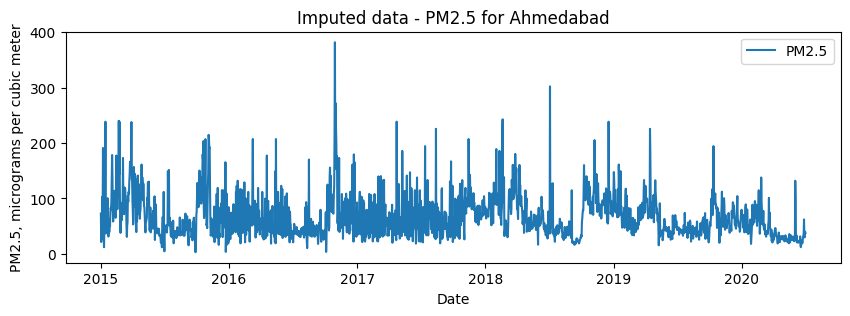

In [17]:
# Approach 2: Interpolation with MICE (Multivariate Imputation by Chained Equations)

# Impute the data
data_imputed = impute(data, target_columns=data.columns)

# Plot the data
plot_indian_city_pollution(data_imputed, scale=False, title="Imputed data")

**Resampling After Imputation: Enhancing Time Series Analysis**

Resampling data to a regular frequency after imputation is crucial for several reasons:

- **Consistent Analysis Assumptions**: Time series models assume data points are evenly spaced. Resampling ensures this, improving the validity of model assumptions.

- **Model Performance**: Uniformly spaced data can enhance model accuracy by simplifying pattern recognition.

- **Aligning Multiple Series**: For analyses involving multiple datasets, resampling ensures all data aligns perfectly, allowing for accurate comparisons and aggregations.

- **Simplified Feature Engineering**: Regular intervals make generating features like rolling averages more straightforward and accurate.

- **Accurate Aggregations**: Uniform time intervals allow for precise data summarization, crucial for reporting and insights.

- **Reduced Sampling Bias**: Resampling mitigates bias introduced during imputation, ensuring the dataset accurately reflects the time series.

Resampling after filling in missing values is a key step to prepare your data for in-depth time series analysis, ensuring consistency, improving model performance, and enabling accurate insights.



No gaps in data


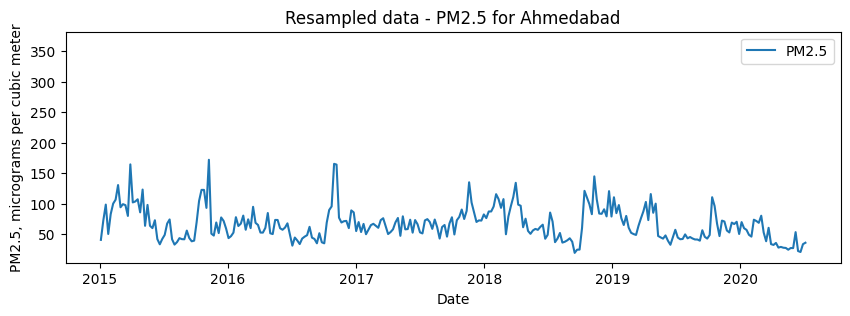

In [21]:
# Resampling to ensure that the data is at a regular frequency

# Resample the data
data_resampled = data_imputed.resample("w").mean()

# Plot the data
plot_indian_city_pollution(data_resampled, scale=False, title="Resampled data",
                           set_y_axis_limits=(data["PM2.5"].min(), data["PM2.5"].max()))

# Noise and outliers
 Real-world time series data often contains noise or outliers that can negatively impact forecasting accuracy. You can use rolling window functions with pandas to smooth the data and reduce the impact of noise.

In [22]:
# load the data
city_name = "Hyderabad"
dataset_object = next(india_pollution(city_list=[city_name], raw=True))

# get the data from the Dataset object
data = dataset_object.values

print(data.head())

INFO:root:Path /Users/frankkelly/Dropbox/Projects-new/india_air_pollution_study/data/air-quality-data-in-india exists
INFO:root:Getting list of city names
INFO:root:Path /Users/frankkelly/Dropbox/Projects-new/india_air_pollution_study/data/air-quality-data-in-india exists


            PM2.5  PM10     O3    CO   SO2    NO2
Date                                             
2015-01-04    NaN   NaN  30.34  0.30  2.58  17.19
2015-01-05    NaN   NaN  31.28  0.23  5.19   9.69
2015-01-06    NaN   NaN  28.56  0.31  9.09  22.02
2015-01-07    NaN   NaN  31.08  0.53  9.03  40.08
2015-01-08    NaN   NaN  35.72  0.44  8.47  33.02


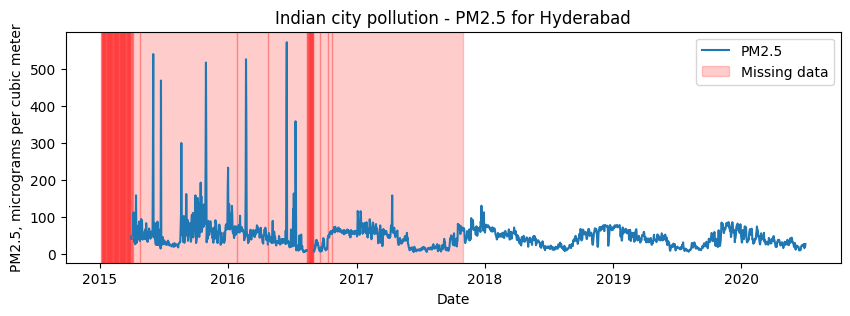

In [23]:
plot_indian_city_pollution(data, scale=False)

## Moving average
A moving average can help to smooth out random noise in time series data. It calculates the average of a specified number of data points and slides this window over the data to produce a smoothed version of the original time series.

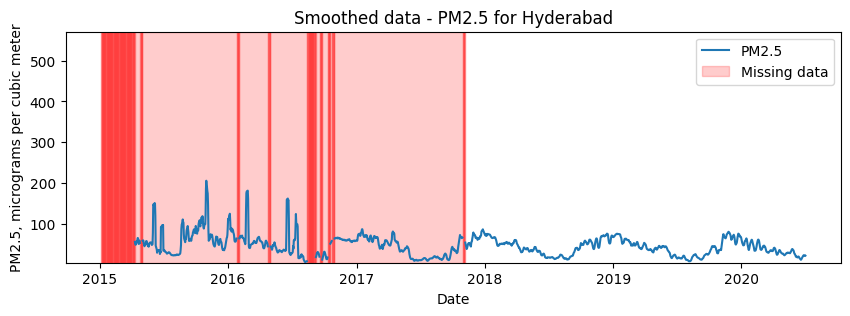

In [24]:
# Moving average to smooth the data

# Resample the data
data_smoothed = data.rolling(7).mean()

# Plot the data
plot_indian_city_pollution(data_smoothed, scale=False, title="Smoothed data",
                           set_y_axis_limits=(data["PM2.5"].min(), data["PM2.5"].max()))


## Exponential Smoothing for Data Smoothing

Exponential smoothing is a time-series forecasting method for smoothing data using an exponential window function. It's particularly useful for reducing noise and forecasting trends in data. By applying exponential smoothing to PM2.5 pollution data, we aim to highlight underlying trends by dampening the effects of random fluctuations.

### Pros:
- **Highlight Trends**: Efficiently reveals underlying trends in the data, making it easier to identify patterns over time.
- **Flexibility**: The `span` parameter allows for adjusting the level of smoothing, offering control over how responsive the smoothed data is to changes.
- **Simplicity and Speed**: Easy to apply and computationally efficient, making it suitable for large datasets and real-time analysis.

### Cons:
- **Smoothing vs. Reality**: While smoothing helps in highlighting trends, it may also obscure short-term fluctuations that could be significant.
- **Parameter Sensitivity**: The choice of the `span` parameter greatly affects the results; inappropriate values can either over-smooth or under-smooth the data.
- **Less Effective for Non-Trend Data**: Best suited for data with clear trends; may not be as effective for stationary time series where values fluctuate around a constant mean.

The code snippet demonstrates how exponential smoothing is applied to PM2.5 pollution data, resulting in a dataset that highlights long-term trends while reducing the impact of short-term anomalies. This method can be useful for reducing the impact of noise and outliers.

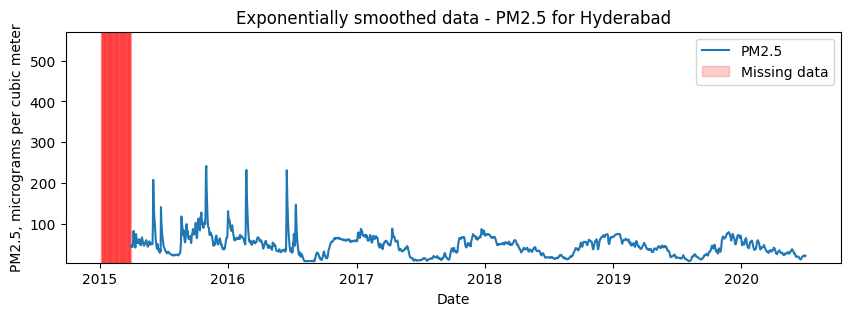

In [25]:
# Exponential smoothing to smooth the data

data_exp_smoothed = data.ewm(span=7).mean()

# Plot the data
plot_indian_city_pollution(data_exp_smoothed, scale=False, title="Exponentially smoothed data",
                           set_y_axis_limits=(data["PM2.5"].min(), data["PM2.5"].max()))

## Z-Score Method for Outlier Removal in PM2.5 Data

Utilising the Z-score method is an effective statistical technique for identifying and removing outliers from PM2.5 pollution data. This method calculates the Z-score of each data point, which measures how far and in what direction, a data point deviates from the mean, in terms of standard deviations. Data points with a Z-score above a defined threshold (e.g., 3) are considered outliers and can be filtered out.

### Pros:
- **Standardisation**: Offers a standardised way of identifying outliers, making it easy to compare across different datasets.
- **Effectiveness**: Efficient at detecting outliers in data with a Gaussian (normal) distribution.
- **Simplicity**: The calculation and implementation are straightforward, especially with libraries like NumPy.

### Cons:
- **Assumption Dependent**: Assumes data follows a normal distribution, which might not hold true for all datasets, especially for environmental data like PM2.5.
- **Potential Data Loss**: Can result in valuable data loss if the threshold is not carefully chosen, especially in cases where extreme values are genuine.
- **Sensitivity to Large Datasets**: In very large datasets, the Z-score method might not effectively differentiate between outliers and naturally occurring extremes.

The code snippet demonstrates how to apply the Z-score method to filter out outliers from PM2.5 pollution data, potentially cleaning the dataset for more accurate analysis and visualisation. While it's a powerful method for handling


filtered_entries: Date
2015-01-04    False
2015-01-05    False
2015-01-06    False
2015-01-07    False
2015-01-08    False
              ...  
2020-06-27     True
2020-06-28     True
2020-06-29     True
2020-06-30     True
2020-07-01     True
Freq: D, Name: PM2.5, Length: 2006, dtype: bool
No gaps in data


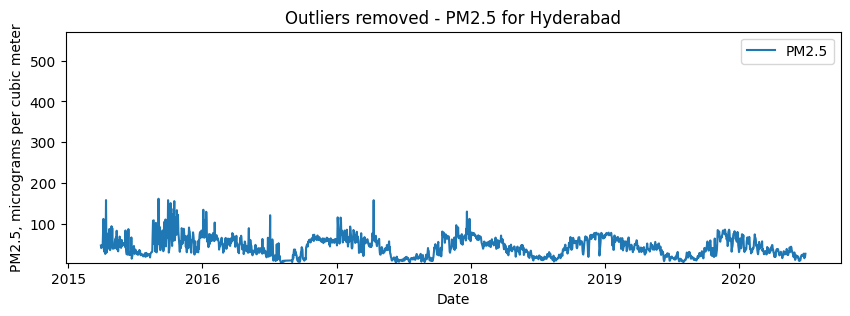

In [27]:
# Z-score method to remove outliers (PM2.5)

import numpy as np

threshold = 3

z_scores = (data["PM2.5"] - data["PM2.5"].mean()) / data["PM2.5"].std()
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < threshold)
print(f"filtered_entries: {filtered_entries}")

data_outliers_removed = data[filtered_entries]

# Plot the data
plot_indian_city_pollution(data_outliers_removed, scale=False, title="Outliers removed",
                           set_y_axis_limits=(data["PM2.5"].min(), data["PM2.5"].max()))